In [2]:
import numpy as np
import pandas
import pylab as plt                                # matplotlib的一个子包
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error   # 平方绝对误差
from sklearn.metrics import r2_score              # R square
from utils import eemd_tools, data_tools, networks_factory, data_metrics
from utils.constants import const

Using TensorFlow backend.
D:\Users\msn\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\msn\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\msn\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\msn\Anaconda3\envs\tensorflow

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

# 导入数据

In [4]:
dataset, dates = data_tools.load_data_from_csv(const.PROJECT_DIR + "/data/apple_interpolate.csv")
data_multi = np.load(const.PROJECT_DIR + "/data/eemd/apple/data_multi.npy")
print("# shape", data_multi.shape)  # not .shape()

# shape (1901, 4)


## data preprocessing

In [5]:
# normalize features
scaler = data_tools.Ne_MinMaxScaler
scaled = scaler.fit_transform(data_multi)

output = 1
lag = 13

reframed = data_tools.series_to_supervised(scaled, lag, output)
# drop columns we don't want to predict
index_drop = [-j-1 for j in range(data_multi.shape[1] - 1)]
reframed.drop(reframed.columns[index_drop], axis=1, inplace=True)
data_supervised = reframed.values
print("# shape:", reframed.shape)
print(len(data_multi) == len(reframed) + lag)
# print(reframed.head(3))

# split into train and test sets
train_size = int(len(data_supervised) * const.TRAIN_SCALE)
test_size = len(data_supervised) - train_size
train_data, test_data = data_supervised[0:train_size,:], data_supervised[train_size:len(data_multi),:]
print(len(train_data), len(test_data))
print(len(data_supervised) == len(train_data) + len(test_data)) 
# print(train_data)

# shape: (1888, 53)
True
1510 378
True


In [6]:
# split into input and outputs
train_X, train_Y = train_data[:, :-1], train_data[:, -1]
test_X, test_Y = test_data[:, :-1], test_data[:, -1]
print("# shape:", train_X.shape)
print("# shape:", train_Y.shape)

# shape: (1510, 52)
# shape: (1510,)


# LSTM

In [7]:
time_steps = lag
n_dims = 4  # magic number !
n_lstm_neurons = 32
n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE

In [8]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]//time_steps))
test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]//time_steps))
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(1510, 13, 4) (1510,)
(378, 13, 4) (378,)


## test or retrain

In [9]:
from keras.models import load_model

model_name = const.PROJECT_DIR + "/data/eemd/apple/lookback_models/" + str(lag) + '_model.h5'
model = load_model(model_name)

# new model
# s, model = networks_factory.create_lstm_model(lstm_neurons=n_lstm_neurons, hidden_layers=2, 
#                                                           lenth=time_steps, dims=n_dims, n_out=1)

In [10]:
from keras import optimizers
Adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)  # for re-train, low learning rate

# model.compile(loss='mean_squared_error', optimizer=Adam)
# history = model.fit(train_X, train_Y, epochs=n_epoch, batch_size=n_batch_size, validation_data=(test_X, test_Y), 
#                 verbose=2, callbacks=[networks_factory.ES]) 
# print("# Finished Training...")

In [11]:
# make a prediction
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# invert predictions
inv_trainP, inv_trainY = data_tools.inv_transform_multi(scaler, train_X, train_predict, train_Y)
inv_testP, inv_testY = data_tools.inv_transform_multi(scaler, test_X, test_predict, test_Y)

# calculate RMSE, MAPE, Dstat
train_rmse = sqrt(mean_squared_error(inv_trainP, inv_trainY))
test_rmse = sqrt(mean_squared_error(inv_testP, inv_testY))
print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
test_mape = data_metrics.MAPE(inv_testP, inv_testY)
print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
test_ds = data_metrics.Dstat(inv_testP, inv_testY)
print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

Train RMSE: 0.4582, Test RMSE: 0.2821
Train MAPE: 0.0241, Test MAPE: 0.0273
Train Dstat: 0.7674, Test Dstat: 0.6764


In [12]:
# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot predict result

In [13]:
# shift test predictions for plotting
dataset = data_multi[:,0]  # original price
look_back = lag

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = inv_trainP  # index from a to b-1

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+look_back:] = inv_testP

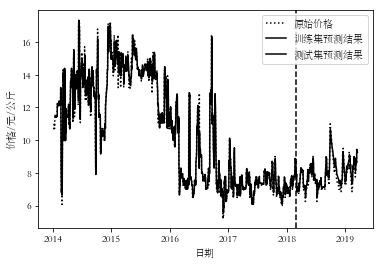

In [14]:
from datetime import datetime

# plot baseline and predictions
# 中文乱码的处理
plt.rcParams['font.family']=['STSong']
plt.rcParams['axes.unicode_minus'] = False
ys, xs = dataset, [datetime.strptime(d, '%Y-%m-%d') for d in dates]

fig = plt.figure(1)
ax1 = plt.subplot(1, 1, 1)
l1, = ax1.plot(xs, dataset, color='black', linestyle=':')
l2, = ax1.plot(xs, trainPredictPlot, color='black', linestyle='-')
l3, = ax1.plot(xs, testPredictPlot, color='black', linestyle='-')
plt.axvline('2018-03', color='k', linestyle='--')

plt.ylabel('价格/元/公斤')
plt.xlabel('日期')
plt.legend([l1, l2, l3], ['原始价格', '训练集预测结果', '测试集预测结果'], loc='upper right')
plt.show()

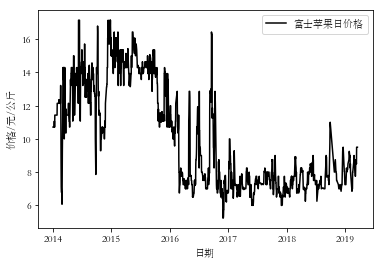

In [15]:
fig = plt.figure(1)
ax1 = plt.subplot(1, 1, 1)
l1, = ax1.plot(xs, dataset, color='black', linestyle='-')

plt.ylabel('价格/元/公斤')
plt.xlabel('日期')
plt.legend([l1], ['富士苹果日价格'], loc='upper right')
plt.show()

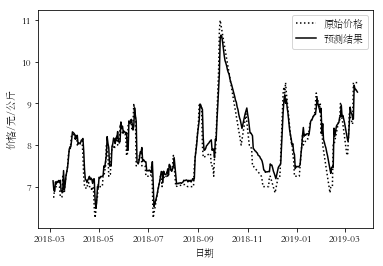

In [16]:
xs = np.array(xs)
xs = xs[-378:]
price = dataset[-378:]
testP = testPredictPlot[-378:]

fig = plt.figure(1)
ax1 = plt.subplot(1, 1, 1)
l1, = ax1.plot(xs, price, color='black', linestyle=':')
l2, = ax1.plot(xs, testP, color='black', linestyle='-')

plt.ylabel('价格/元/公斤')
plt.xlabel('日期')
plt.legend([l1, l2], ['原始价格', '预测结果'], loc='upper right')
plt.show()